In [ ]:
pip uninstall numpy pandas scikit-learn matplotlib -y

Found existing installation: numpy 1.26.4
Uninstalling numpy-1.26.4:
  Successfully uninstalled numpy-1.26.4
Found existing installation: pandas 2.2.3
Uninstalling pandas-2.2.3:
  Successfully uninstalled pandas-2.2.3
Found existing installation: scikit-learn 1.6.1
Uninstalling scikit-learn-1.6.1:
  Successfully uninstalled scikit-learn-1.6.1
Found existing installation: matplotlib 3.10.1
Uninstalling matplotlib-3.10.1:
  Successfully uninstalled matplotlib-3.10.1


In [ ]:
pip install catboost

  Using cached numpy-1.26.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (61 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.9/89.9 kB 4.0 MB/s eta 0:00:00
Using cached numpy-1.26.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (18.3 MB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.1/13.1 MB 82.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 75.0 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
umap-learn 0.5.7 requires scikit-learn>=0.22, which is not installed.
librosa 0.11.0 requires scikit-learn>=1.1.0, which is not installed.
pynndescent 0.5.13 requires scikit-learn>=0.18, which is not installed.
sentence-transformers 3.4.1 requires scikit-learn, which is not installed.
hdbscan 0.8.40 requires scikit-learn>=0.20, which is not installed.
mlxtend 0.23.4 requires scikit-learn

In [ ]:
pip install pandas scikit-learn matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.5/13.5 MB 71.9 MB/s eta 0:00:00


In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder, MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score
from matplotlib import pyplot as plt
import catboost as cb

In [2]:
from catboost import CatBoostClassifier

In [20]:
from visualization_features import get_feature_importance, plot_feature_importance, evaluate_model

In [3]:
df = pd.read_excel('data_final_res.xlsx')

date_columns = ['Дата публикации',
                   'Дата окончания приема заявок / Дата планового окончания исполнения контракта / Плановая дата публикации лота по ППГ',
                   'Дата начала подачи заявок / Дата начала исполнения контракта / Дата публикации ППГ',
                   'Дата окончания проведения торгов']

for col in date_columns:
    df[col] = pd.to_datetime(df[col], format='%Y-%m-%d', errors='coerce')

In [4]:
def clean_region_data(region):
    if pd.isna(region):
        return region

    if ';' in region:
        region = region.split(';')[0].strip()

    if '(' in region:
        region = region.split('(')[0].strip()

    return region

df['Регион поставки'] = df['Регион поставки'].apply(clean_region_data)

print("Уникальные значения после очистки:")
print(sorted(df['Регион поставки'].unique()))

Уникальные значения после очистки:
['Алтайский край', 'Амурская область', 'Архангельская область', 'Астраханская область', 'Байконур', 'Белгородская область', 'Брянская область', 'Владимирская область', 'Волгоградская область', 'Вологодская область', 'Воронежская область', 'Донецкая Народная Республика', 'Еврейская автономная область', 'Забайкальский край', 'Ивановская область', 'Иркутская область', 'Кабардино-Балкарская Республика', 'Калининградская область', 'Калужская область', 'Камчатский край', 'Карачаево-Черкесская Республика', 'Кемеровская область - Кузбасс', 'Кировская область', 'Костромская область', 'Краснодарский край', 'Красноярский край', 'Курганская область', 'Курская область', 'Ленинградская область', 'Липецкая область', 'Магаданская область', 'Москва', 'Московская область', 'Мурманская область', 'Ненецкий автономный округ', 'Нижегородская область', 'Новгородская область', 'Новосибирская область', 'Омская область', 'Оренбургская область', 'Орловская область', 'Пензенская

In [5]:
df['Год'] = df['Дата публикации'].dt.year
df['Месяц'] = df['Дата публикации'].dt.month

train_data = df[df['Год'].isin(range(2019, 2024))]
test_data = df[df['Год'].isin(range(2024, 2026))]

# НОВЫЕ ПРИЗНАКИ

df['Процент побед'] = train_data.groupby(['ИНН поставщика'])['Победитель'].transform(lambda x: (x == 'Победитель').sum() / len(x))

df['Кол-во участий по региону'] = train_data.groupby(['ИНН поставщика', 'Регион поставки'])['Победитель'].transform('count')
df['Кол-во побед по региону'] = train_data.groupby(['ИНН поставщика', 'Регион поставки'])['Победитель'].transform(lambda x: (x == 'Победитель').sum())
df['Процент побед по региону'] = df['Кол-во побед по региону'] / df['Кол-во участий по региону']

df['Кол-во участий по заказчику'] = train_data.groupby(['ИНН поставщика', 'Заказчик'])['Победитель'].transform('count')
df['Кол-во побед по заказчику'] = train_data.groupby(['ИНН поставщика', 'Заказчик'])['Победитель'].transform(lambda x: (x == 'Победитель').sum())
df['Процент побед по заказчику'] = df['Кол-во побед по заказчику'] / df['Кол-во участий по заказчику']

df['Кол-во участий по сфере'] = train_data.groupby(['ИНН поставщика', 'Сфера деятельности'])['Победитель'].transform('count')
df['Кол-во побед по сфере'] = train_data.groupby(['ИНН поставщика', 'Сфера деятельности'])['Победитель'].transform(lambda x: (x == 'Победитель').sum())
df['Процент побед по сфере'] = df['Кол-во побед по сфере'] / df['Кол-во участий по сфере']

df['Общее кол-во участий'] = train_data.groupby('ИНН поставщика')['Победитель'].transform('count')
df['Общее кол-во побед'] = train_data.groupby('ИНН поставщика')['Победитель'].transform(lambda x: (x == 'Победитель').sum())

df['Среднее снижение цены'] = train_data.groupby('ИНН поставщика')['Снижение на торгах,%'].transform('mean')

df['Последняя дата публикации'] = df.groupby("ИНН поставщика")["Дата публикации"].transform("max")
df['Последняя дата публикации'] = pd.to_datetime(df[col], format='%Y-%m-%d', errors='coerce')

df.to_csv('processed_data.csv', index=False)

In [6]:
df['Target'] = (df['Победитель'] == 'Победитель').astype(int)

numerical_features = [
    'Процент побед', 'Кол-во участий по региону', 'Кол-во побед по региону',
    'Процент побед по региону', 'Кол-во участий по заказчику', 'Кол-во побед по заказчику',
    'Процент побед по заказчику', 'Кол-во участий по сфере', 'Кол-во побед по сфере',
    'Процент побед по сфере', 'Общее кол-во участий', 'Общее кол-во побед',
    'Среднее снижение цены', 'Стоимость(руб.) Заказчик'
]

categorical_features = [
    'Уровень', 'Регион поставки',
    'Сфера деятельности',
    'Форма публикации',
    'Тип торгов',
    'РНП сейчас',
    'РНП ранее'
]

time_features = ['Год', 'Месяц', 'Последняя дата публикации']

train_data = df[df['Год'].isin(range(2019, 2024))]
test_data = df[df['Год'].isin(range(2024, 2026))]

feature_columns = numerical_features + categorical_features + time_features

X_train = train_data[feature_columns].copy()
y_train = train_data['Target']
X_test = test_data[feature_columns].copy()
y_test = test_data['Target']

def preprocess_categorical_features(train_data, test_data, categorical_features, min_frequency=0.001):
    processed_train = train_data.copy()
    processed_test = test_data.copy()

    all_data = pd.concat([processed_train[categorical_features], processed_test[categorical_features]])

    for feature in categorical_features:
        value_counts = all_data[feature].value_counts(normalize=True)
        rare_categories = value_counts[value_counts < min_frequency].index

        processed_train[feature] = processed_train[feature].apply(lambda x: 'Other' if x in rare_categories else x)
        processed_test[feature] = processed_test[feature].apply(lambda x: 'Other' if x in rare_categories or x not in value_counts.index else x)

        processed_train[feature] = processed_train[feature].fillna('Unknown')
        processed_test[feature] = processed_test[feature].fillna('Unknown')

    return processed_train, processed_test

for col in numerical_features + time_features:
    X_train[col] = X_train[col].fillna(X_train[col].mean())
    X_test[col] = X_test[col].fillna(X_train[col].mean())

X_train, X_test = preprocess_categorical_features(X_train, X_test, categorical_features)

categorical_encoder = OneHotEncoder(
    drop='first',
    sparse_output=False,
    handle_unknown='ignore',
    min_frequency=0.001
)

all_categorical_data = pd.concat([X_train[categorical_features], X_test[categorical_features]])
categorical_encoder.fit(all_categorical_data)

OneHotEncoder(drop='first', handle_unknown='ignore', min_frequency=0.001,
              sparse_output=False)

In [18]:
from catboost import CatBoostClassifier
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import FunctionTransformer

class CatBoostModel:
    def __init__(self, numerical_features, categorical_features, time_features):
        self.numerical_features = numerical_features
        self.categorical_features = categorical_features
        self.time_features = time_features
        self.model = None
        self.param_grid = {
            'classifier__iterations': [100],
            'classifier__learning_rate': [0.01, 0.1],
            'classifier__depth': [4, 6, 8],
            'classifier__l2_leaf_reg': [1, 3, 5, 7],
            'classifier__border_count': [32, 64]
        }

    def _convert_datetime(self, X):
        X = X.copy()
        for col in self.time_features:
            if col in X.columns:
                X[col] = X[col].astype(np.int64) // 10**9  # конвертация в unix timestamp - в сек
        return X

    def create_pipeline(self, categorical_encoder=None):
        if categorical_encoder is None:
            categorical_encoder = OneHotEncoder(
                drop='first',
                sparse_output=False,
                handle_unknown='ignore',
                min_frequency=0.001
            )

        datetime_transformer = FunctionTransformer(
            func=lambda x: x.astype(np.int64) // 10**9,
            validate=False
        )

        preprocessor = ColumnTransformer(
            transformers=[
                ('num', StandardScaler(), self.numerical_features),
                ('time', datetime_transformer, self.time_features),
                ('cat', categorical_encoder, self.categorical_features)
            ],
            remainder='passthrough'
        )

        self.pipeline = Pipeline([
            ('preprocessor', preprocessor),
            ('classifier', CatBoostClassifier(
                eval_metric='AUC',
                random_seed=42,
                verbose=False,
                allow_writing_files=False
            ))
        ])
        return self

    def train(self, X_train, y_train, cv=3):
        X_train = self._convert_datetime(X_train)

        self.model = GridSearchCV(
            self.pipeline,
            self.param_grid,
            cv=cv,
            scoring='roc_auc',
            n_jobs=-1,
            error_score='raise'
        )
        self.model.fit(X_train, y_train)
        return self

    def predict(self, X):
        X = self._convert_datetime(X)
        return self.model.predict_proba(X)[:, 1]

    def get_best_params(self):
        return self.model.best_params_

    def evaluate(self, X_test, y_test):
        y_pred = self.predict(X_test)
        return roc_auc_score(y_test, y_pred)

In [19]:
catboost_model = CatBoostModel(numerical_features, categorical_features, time_features)
catboost_model.create_pipeline().train(X_train, y_train)

score = catboost_model.evaluate(X_test, y_test)
print(f"ROC-AUC на тестовой выборке: {score:.4f}")

best_params = catboost_model.get_best_params()
print("Лучшие параметры:", best_params)

ROC-AUC на тестовой выборке: 0.8842
Лучшие параметры: {'classifier__border_count': 32, 'classifier__depth': 8, 'classifier__iterations': 100, 'classifier__l2_leaf_reg': 3, 'classifier__learning_rate': 0.1}


XGBoost Metrics:
Accuracy: 0.6924
Precision: 0.6931
Recall: 0.9953
F1-Score: 0.8172
ROC-AUC: 0.8842

Confusion Matrix:


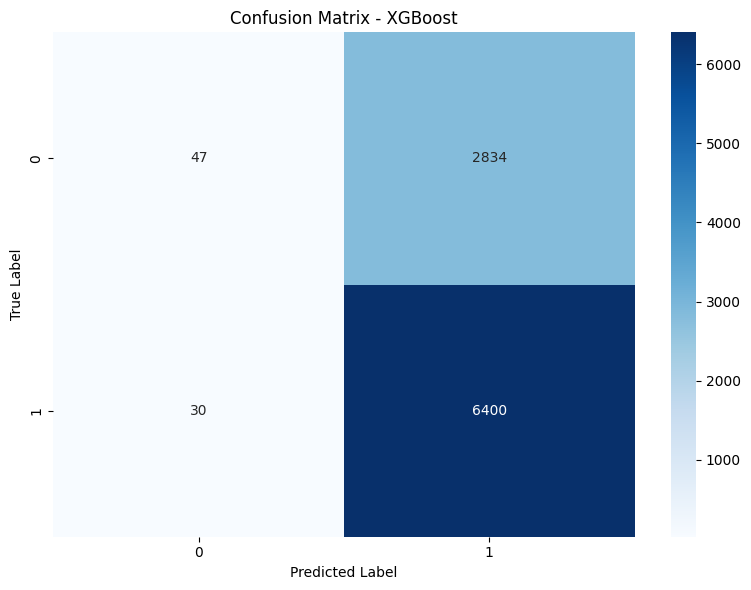

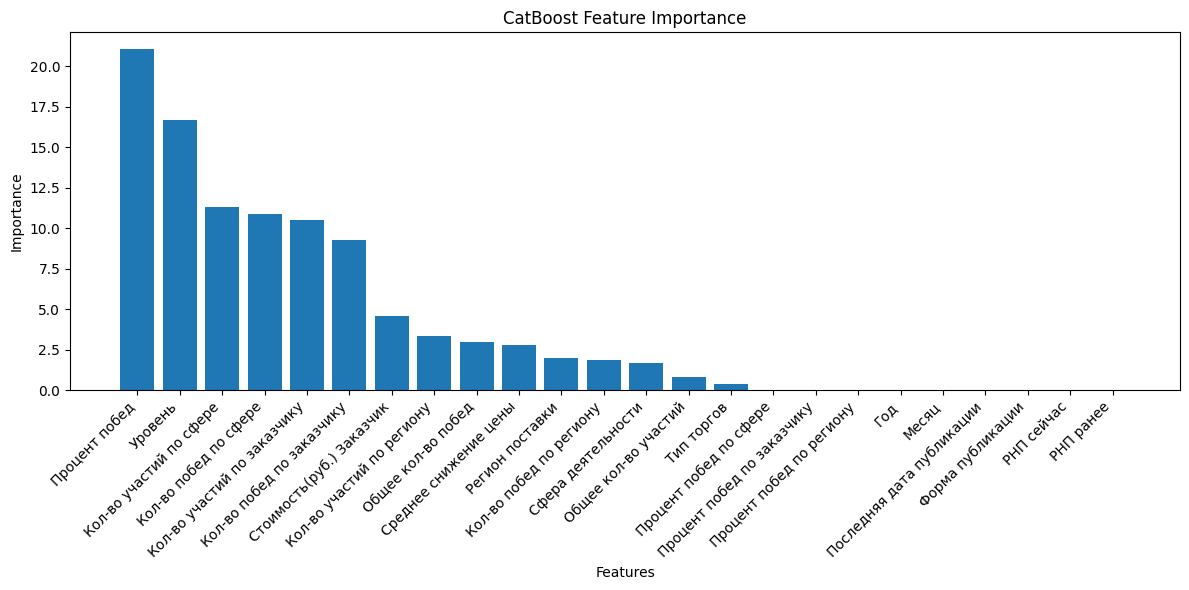


Важность признаков:
                        feature  importance
0                 Процент побед   21.027046
17                      Уровень   16.693678
7       Кол-во участий по сфере   11.284602
8         Кол-во побед по сфере   10.844297
4   Кол-во участий по заказчику   10.489173
5     Кол-во побед по заказчику    9.259091
13     Стоимость(руб.) Заказчик    4.587025
1     Кол-во участий по региону    3.331948
11           Общее кол-во побед    2.990459
12        Среднее снижение цены    2.798157
18              Регион поставки    1.985112
2       Кол-во побед по региону    1.859439
19           Сфера деятельности    1.664158
10         Общее кол-во участий    0.786480
21                   Тип торгов    0.399333
9        Процент побед по сфере    0.000000
6    Процент побед по заказчику    0.000000
3      Процент побед по региону    0.000000
14                          Год    0.000000
15                        Месяц    0.000000
16    Последняя дата публикации    0.000000
20         

In [21]:
y_pred_proba = catboost_model.predict(X_test)
y_pred = (y_pred_proba > 0.5).astype(int)
evaluate_model("XGBoost", y_test, y_pred, y_pred_proba)

importance_df = get_feature_importance(
    catboost_model.model.best_estimator_.named_steps['classifier'],
    numerical_features,
    time_features,
    categorical_features,
    catboost_model.model.best_estimator_.named_steps['preprocessor'].named_transformers_['cat']
)
plot_feature_importance(importance_df, "CatBoost Feature Importance")